In [ ]:
# IMPORTS #
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
import seaborn as sns
import os,sys
config_path = os.path.abspath(os.path.join(os.getcwd(), '..','..', 'Loading_Database'))
sys.path.append(config_path)
from configuration import *

In [21]:
# CONNECT TO DB #

conn = psycopg2.connect(DATABASE_URL)
print("Connected to Azure PostgreSQL!")

Connected to Azure PostgreSQL!


In [31]:
################ Non reply tweets query #######################

# Query: Non-reply tweets (in_reply_to_status_id is NULL)
non_reply_df = pd.read_sql("""
    SELECT COUNT(*) AS non_reply_tweet_count
    FROM "tweets"
    WHERE in_reply_to_status_id IS NULL;
""", conn)

# Query: Total tweets
total_df = pd.read_sql("""
    SELECT COUNT(*) AS total_tweet_count
    FROM "tweets";
""", conn)

# Extract values
non_reply_count = int(non_reply_df.iloc[0]['non_reply_tweet_count'])
total_count = int(total_df.iloc[0]['total_tweet_count'])
reply_count = total_count - non_reply_count
print(non_reply_count)
print(total_count)
print(reply_count)

9697
14387
4690


C:\Users\pavel\AppData\Local\Temp\ipykernel_2196\3592356260.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  non_reply_df = pd.read_sql("""
C:\Users\pavel\AppData\Local\Temp\ipykernel_2196\3592356260.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_df = pd.read_sql("""


In [4]:
######################### Language tweets query #####################

lang_df = pd.read_sql("""
    SELECT lang, COUNT(*) AS tweet_count
    FROM "tweets"
    GROUP BY lang
    ORDER BY tweet_count DESC;
""", conn)
print(lang_df.head())

  lang  tweet_count
0   en        11228
1   es          670
2   fr          536
3   nl          445
4  und          333


C:\Users\pavel\AppData\Local\Temp\ipykernel_2196\3787923715.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lang_df = pd.read_sql("""


In [5]:
##############  Timestamp distribution query #################3

time_df = pd.read_sql("""
    SELECT DATE(created_at) AS day, COUNT(*) AS tweet_count
    FROM "tweets"
    GROUP BY day
    ORDER BY day;
""", conn)
print(time_df.head())


## 
time_df['day'] = pd.to_datetime(time_df['day'])
time_df = time_df.set_index('day')

# Resample to monthly total tweets
monthly_df = time_df.resample('M').sum().reset_index()

          day  tweet_count
0  2019-05-22         7894
1  2019-05-23         6493


C:\Users\pavel\AppData\Local\Temp\ipykernel_2196\2787896731.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_df = pd.read_sql("""
C:\Users\pavel\AppData\Local\Temp\ipykernel_2196\2787896731.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = time_df.resample('M').sum().reset_index()


In [6]:
################## Tweet categories query (Extra) ###############
tweet_flags_df = pd.read_sql("""
    SELECT 
        in_reply_to_status_id IS NOT NULL AS is_reply,
        retweeted_status_id IS NOT NULL AS is_retweet,
        is_quote_status IS TRUE AS is_quote
    FROM "tweets"
    TABLESAMPLE SYSTEM (0.001);  -- adjust % here for more rows
""", conn)


C:\Users\pavel\AppData\Local\Temp\ipykernel_2196\3111173289.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tweet_flags_df = pd.read_sql("""


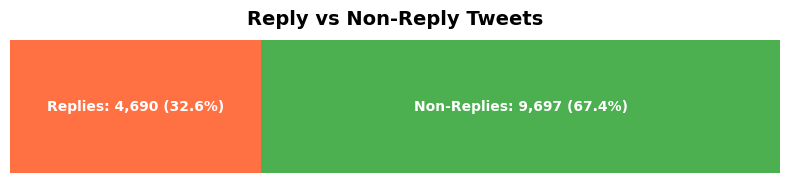

In [9]:
# Reply vs Non-reply
# Prepare data
categories = ['Replies', 'Non-Replies']
values = [reply_count, non_reply_count]
colors = ['#FF7043', '#4CAF50']  # reply = red, non-reply = green

# Plot
plt.figure(figsize=(8, 2))
plt.barh(
    y=0,
    width=values,
    left=[0, values[0]],
    color=colors,
    height=0.5
)

# Labels on bar segments
for i, (v, label) in enumerate(zip(values, categories)):
    percent = f"{v/total_count:.1%}"
    plt.text(
        sum(values[:i]) + v / 2,
        0,
        f"{label}: {v:,} ({percent})",
        ha='center',
        va='center',
        fontsize=10,
        color='white',
        fontweight='bold'
    )

plt.title("Reply vs Non-Reply Tweets", fontsize=14, fontweight='bold')
plt.axis('off')
plt.xlim(0, total_count)
plt.tight_layout()
plt.show()


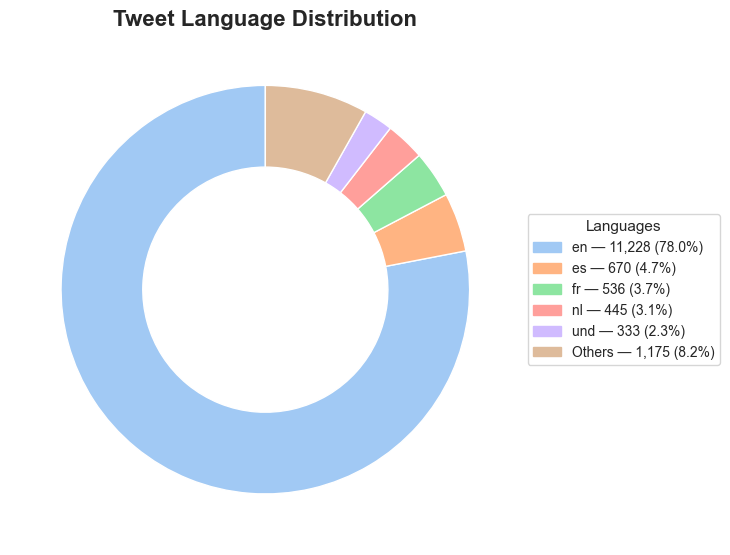

In [30]:

threshold = 0.02  # 2% - 'Others' grouping threshhold

lang_df['pct'] = lang_df['tweet_count'] / lang_df['tweet_count'].sum()
major_langs = lang_df[lang_df['pct'] >= threshold].copy()
other_langs = lang_df[lang_df['pct'] < threshold].copy()

# Aggregate the "others"
if not other_langs.empty:
    others_row = pd.DataFrame({
        'lang': ['Others'],
        'tweet_count': [other_langs['tweet_count'].sum()],
        'pct': [other_langs['pct'].sum()]
    })
    lang_df_final = pd.concat([major_langs, others_row], ignore_index=True)
else:
    lang_df_final = major_langs

# === STEP 2: Generate the donut plot ===
colors = sns.color_palette('pastel', n_colors=len(lang_df_final))

legend_labels = [
    f"{lang} — {count:,} ({pct:.1%})"
    for lang, count, pct in zip(lang_df_final['lang'], lang_df_final['tweet_count'], lang_df_final['pct'])
]

plt.figure(figsize=(7, 6))
wedges, _ = plt.pie(
    lang_df_final['tweet_count'],
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')  # Donut-style
)

plt.legend(
    handles=[Patch(color=colors[i], label=legend_labels[i]) for i in range(len(lang_df_final))],
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title="Languages",
    title_fontsize=11
)

plt.title("Tweet Language Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

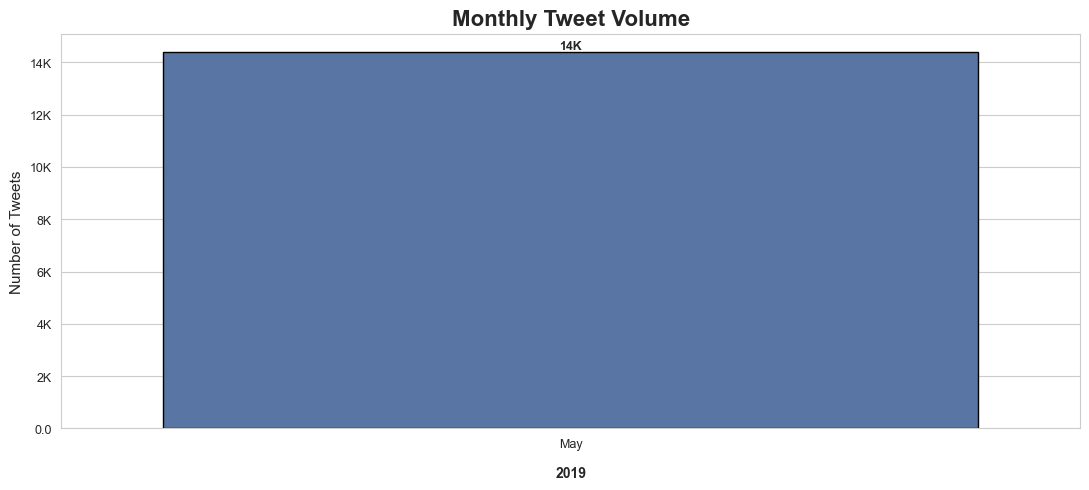

In [ ]:

# Create shorthand number formatter: 255000 → 255K, 1,200,000 → 1.2M
def human_format(num):
    if num >= 1_000_000:
        return f"{num/1_000_000:.2f}M"
    elif num >= 1_000:
        return f"{int(num/1_000)}K"
    else:
        return str(num)

# Format x-axis with month only (we'll label year manually)
monthly_df['month_label'] = monthly_df['day'].dt.strftime('%b')  # e.g., "May", "Jun"
years = monthly_df['day'].dt.year.tolist()

plt.figure(figsize=(11, 5))
sns.set_style("whitegrid")

# Bar chart
barplot = sns.barplot(
    data=monthly_df,
    x='month_label',
    y='tweet_count',
    color='#4C72B0',
    edgecolor='black'
)

# Format y-axis ticks with human numbers
barplot.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: human_format(x)))

# Add data labels on top of bars
for bar, val in zip(barplot.patches, monthly_df['tweet_count']):
    barplot.annotate(
        human_format(val),
        (bar.get_x() + bar.get_width() / 2, val),
        ha='center', va='bottom',
        fontsize=9, fontweight='bold'
    )

# Add year labels under May (first entry) and Jan 2020
for i, year in enumerate(years):
    if (i == 0) or (year != years[i - 1]):  # first of each year
        plt.text(i, -0.1 * max(monthly_df['tweet_count']),
                 str(year),
                 ha='center', va='top', fontsize=10, fontweight='bold')

# Clean up
plt.title("Monthly Tweet Volume", fontsize=16, fontweight='bold')
plt.xlabel("")  # no x-axis label
plt.ylabel("Number of Tweets", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()
